The NBA playoffs are coming soon and the brckets are almost completely set. This notebook aims to make predictions for these playoffs.

This project delivers value by:
- revealing indicators of success that tend to appear in the NBA
- providing data to identify strategies that need to be adjusted

In [1]:
import sqlalchemy
from os import environ

import numpy as np
import pandas as pd

The data used in this projects are the traditional team box scores during the regular and postseasons from the 1989-90 to 2020-21. These box scores represent the team's sum (in the case of percentages, the total percentages) of each statistic in a game.

Data was sourced from the NBA's official website: https://www.nba.com/stats/teams/boxscores/

The data is stored locally in a MySQL database and is imported as follows:

In [63]:
engine = sqlalchemy.create_engine("mariadb+mariadbconnector://"+environ.get("USER")+\
                                  ":"+environ.get("PSWD")+"@127.0.0.1:3306/nba")

In [93]:
command = "SELECT Teams.Name AS Team, Team_box_scores.* FROM Team_box_scores"+\
" INNER JOIN Teams ON Team_box_scores.Team_ID = Teams.ID "

df = pd.read_sql(command,engine)

In [94]:
drop_columns = ['Team_ID']
df.drop(columns=drop_columns,inplace = True)

Season_type will be used to differentiate regular season from playoffs. Variable gdf.index is a tuple of size 3 of the format: (Team, season_type, year)

In [95]:
df["Season_type"] = df["Game_ID"].str.slice(0,3) # first three digits represent the season type
df["Year"] = df["Game_ID"].str.slice(3,5) # 4th and 5th digit represent year the season started
df['Playoffs'] = True

In [96]:
gdf = df.groupby(['Team','Season_type','Year']).count()

Change Playoffs variable to 0 if there is no playoff data for that team that year.

In [97]:
for t,s,y in gdf.index:
    if(s=='004'):
        l = gdf.loc[t].loc[s].index
        df.loc[df['Team']==t,"Playoffs"] = df.loc[df['Team']==t,"Playoffs"].where(df["Year"].isin(l),False)

Now that the playoff status has been established, the temporary variables can be removed

In [98]:
df.loc[:,:] = df.loc[df['Season_type']=='002']
drop_cols = ['Season_type','Year']
df.drop(columns = drop_cols,inplace=True)

# Basic exploration

The data is clean with only 3 null values for the variable P3P (3P%) which means that there were three games over the last 33 years in which a team did not attempt 3 point shots. These null values for P3P can be replaced with a 0 because in this case, it is semantically the same thing.

In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79504 entries, 0 to 79503
Data columns (total 25 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Team      74454 non-null  object 
 1   Game_ID   74454 non-null  object 
 2   Matchup   74454 non-null  object 
 3   Game_day  74454 non-null  object 
 4   Result    74454 non-null  object 
 5   MINS      74454 non-null  float64
 6   PTS       74454 non-null  float64
 7   FGM       74454 non-null  float64
 8   FGA       74454 non-null  float64
 9   FGP       74454 non-null  float64
 10  PM3       74454 non-null  float64
 11  PA3       74454 non-null  float64
 12  P3P       74351 non-null  float64
 13  FTM       74454 non-null  float64
 14  FTA       74454 non-null  float64
 15  FTP       74454 non-null  float64
 16  OREB      74454 non-null  float64
 17  DREB      74454 non-null  float64
 18  REB       74454 non-null  float64
 19  AST       74454 non-null  float64
 20  TOV       74454 non-null  fl

In [101]:
df.fillna(value={'P3P':0},inplace=True)

Below is the histogram for each numeric variable

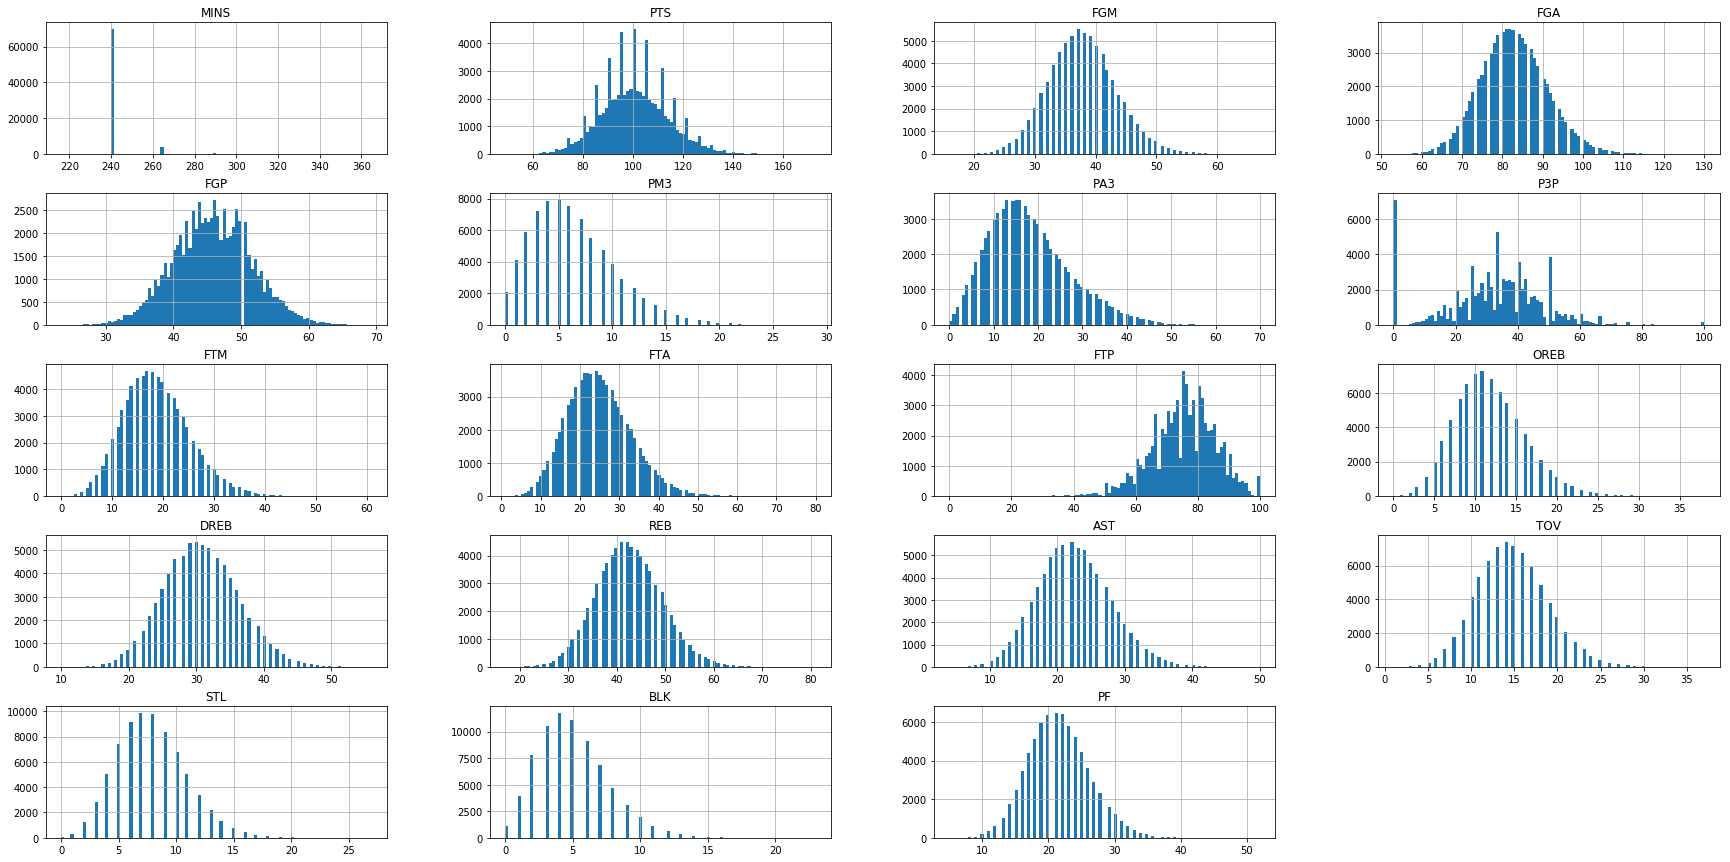

In [102]:
import matplotlib.pyplot as plt
df.hist(bins = 100,figsize=(30,15))
plt.show()

With the exception of the Minutes played, all other numeric statistics are roughly normally distributed. This pattern is typical throughout basketball (from team performance to individual performance) and it is this property that that will be useful for a number of machine learning methods.

Minutes played will not follow a normal distribution because most games typically end in regulation and increasingly less every subsequent overtime period. It may be difficult to use minutes played as a predictor to make the playoffs.

# Test set allocation
Best practice dictates that a test set must now be created and unseen the until models can be tested.

Since there are a large number of records $\approx$ 75K, the data can be randomly sampled. The test size will be 20% of the data. This will be used to evaluate the final model. For reprducability, the random seed will be 10.

Model selection will be done using cross-validation.

In [103]:
from sklearn.model_selection import train_test_split
SEED = 10
test_size = .2

In [104]:
features = ['Result', 'MINS', 'PTS', 'FGM', 'FGA', 'FGP', 'PM3', 'PA3', 'P3P','FTM','FTA',
              'FTP', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK','PF']
dependent = ['Playoffs']
X = df[features]
Y = df[dependent]

In [105]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,random_state=SEED,test_size=test_size)

# Exploratory analysis

In [106]:
explore = pd.concat((x_train,y_train),axis=1)

In [108]:
corr_matrix = explore.corr()

In [116]:
corr_matrix['PTS'].sort_values()

TOV    -0.116918
OREB   -0.000084
BLK     0.064174
PF      0.099441
STL     0.123665
REB     0.175749
FTP     0.189382
MINS    0.190658
DREB    0.212258
PA3     0.256843
FTA     0.268280
FTM     0.324411
P3P     0.329814
FGA     0.399283
PM3     0.416653
AST     0.589306
FGP     0.677125
FGM     0.847338
PTS     1.000000
Name: PTS, dtype: float64

Since teams are ranked within their conference, it could be useful to include the conference a team competes in.

In [18]:
conferences = {'West':['NOP','UTA', 'MEM','PHX', 'POR', 'SAC', 'SAS', 'OKC','DAL', 'DEN', 'GSW', 'HOU','LAC', 'LAL','MIN'],
               'East':[]}

In [19]:
conferences['East'] = [i for i in df['Team'].unique() if i not in conferences['West']]

In [20]:
conferences

{'West': ['NOP',
  'UTA',
  'MEM',
  'PHX',
  'POR',
  'SAC',
  'SAS',
  'OKC',
  'DAL',
  'DEN',
  'GSW',
  'HOU',
  'LAC',
  'LAL',
  'MIN'],
 'East': ['ATL',
  'BOS',
  'CLE',
  'CHI',
  'MIA',
  'MIL',
  'BKN',
  'NYK',
  'ORL',
  'IND',
  'PHI',
  'TOR',
  'WAS',
  'DET',
  'CHA']}